# Install necessary packages

In [ ]:
!pip install -q transformers datasets evaluate segments-ai
!pip -q install accelerate -U

# Import Libraries

In [ ]:
from segments import SegmentsClient
from segments.huggingface import release2dataset
from segments.utils import get_semantic_bitmap
from huggingface_hub import notebook_login
from datasets import load_dataset
import json
from huggingface_hub import hf_hub_download
from torchvision.transforms import ColorJitter
from transformers import SegformerFeatureExtractor
from transformers import SegformerForSemanticSegmentation
import torch
from torch import nn
import evaluate
from transformers import Trainer
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# huggingface login
notebook_login()

# Load the `image segmentation` dataset

In [ ]:
# define an api key into segment.ai site
api_key = '8b7e9a3a40f9b15ca1a97f09c0db9994a47c906f'
segments_client = SegmentsClient(api_key)

In [ ]:
# get the dataset from segment.ai
dataset_identifier = "Christini_Sop/P1-0608-T"
release_name = "v0.0001"

# to load the dataset into huggingface dataset
release = segments_client.get_release(dataset_identifier, release_name)
hf_dataset = release2dataset(release)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [ ]:
# vis image features
hf_dataset.features

{'name': Value(dtype='string', id=None),
 'uuid': Value(dtype='string', id=None),
 'status': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'label.annotations': [{'id': Value(dtype='int32', id=None),
   'category_id': Value(dtype='int32', id=None)}],
 'label.segmentation_bitmap': Image(decode=True, id=None)}

In [ ]:
def convert_segmentation_bitmap(example):
    return {
        "label.segmentation_bitmap":
            get_semantic_bitmap(
                example["label.segmentation_bitmap"],
                example["label.annotations"],
            )
    }


semantic_dataset = hf_dataset.map(
    convert_segmentation_bitmap,
)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [ ]:
semantic_dataset = semantic_dataset.rename_column('image', 'pixel_values')
semantic_dataset = semantic_dataset.rename_column('label.segmentation_bitmap', 'label')
semantic_dataset = semantic_dataset.remove_columns(['name', 'uuid', 'status', 'label.annotations'])

In [ ]:
semantic_dataset.features

{'pixel_values': Image(decode=True, id=None),
 'label': Image(decode=True, id=None)}

# Push dataset into `huggingface` hub
- this would be much easier since we can load the dataset into your workspace much easier

In [ ]:
hf_username = 'tontokoton'
dataset_name = 'artery-ultrasound-siit'

hf_dataset_identifier = f"{hf_username}/{dataset_name}"

# upload the dataset into huggingface
semantic_dataset.push_to_hub(hf_dataset_identifier)

# [start] Load the dataset directly from Huggingface

In [ ]:
# load from the huggingface for usage
hf_username = 'tontokoton'
dataset_name = 'artery-ultrasound-siit'
hf_dataset_identifier = f"{hf_username}/{dataset_name}"

dataset = load_dataset(hf_dataset_identifier)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 3
    })
})

In [ ]:
# visualize dataset properties
dataset['train'][0]

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=864x648>,
 'label': <PIL.TiffImagePlugin.TiffImageFile image mode=I size=864x648>}

In [ ]:
# split the dataset and do some shuffle (this pipeline is for full dataset)
dataset = dataset.shuffle(seed=42)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_dataset = dataset["train"]
test_dataset = dataset["test"]


In [ ]:
train_dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 2
})

In [ ]:
test_dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 1
})

In [ ]:
# define id2label first
id2label = {
    1: 'artery',
    2: 'vein',
    3: 'nerve',
    4: 'muscle1',
    5: 'muscle2',
    6: 'muscle3',
    7: 'muscle4',
    8: 'unknown',
}

In [ ]:
# we will design and experiment this part by ourselves
# this part will be later uploaded to huggingface
# repo_id = f"datasets/{hf_dataset_identifier}"
# filename = "id2label.json"
# id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
num_labels

8

# Feature Extractor with `SegFormer` and Data Augmentation

In [ ]:
feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


In [ ]:
# Set transforms
train_dataset.set_transform(train_transforms)
test_dataset.set_transform(val_transforms)

# Load the `SegFormer` Model

In [ ]:
pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Set the TrainingArguments of `SegFormer`

In [ ]:
from transformers import TrainingArguments

epochs = 50
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-v0"

training_args = TrainingArguments(
    "segformer-b0-finetuned-v0-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=10,
    eval_steps=10,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)


In [ ]:
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i+1]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i+1]}": v for i, v in enumerate(per_category_iou)})

    return metrics

# Train `SegFormer` Model

In [ ]:
# define a trainer for implementation of trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
# train segformer model
trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Artery,Accuracy Vein,Accuracy Nerve,Accuracy Muscle1,Accuracy Muscle2,Accuracy Muscle3,Accuracy Muscle4,Accuracy Unknown,Iou Artery,Iou Vein,Iou Nerve,Iou Muscle1,Iou Muscle2,Iou Muscle3,Iou Muscle4,Iou Unknown
10,1.783500,1.974377,0.062021,0.157193,0.211650,nan,0.083395,0.000000,0.000000,0.233021,0.000177,0.626564,nan,0.000000,0.056338,0.000000,0.000000,0.142249,0.000098,0.297483,0.000000
20,1.477900,1.857829,0.095409,0.179353,0.257606,nan,0.067014,0.000000,0.000000,0.309924,0.000000,0.699182,nan,0.000000,0.067014,0.000000,0.000000,0.185657,0.000000,0.415189,nan
30,1.343400,1.675901,0.123927,0.201354,0.274311,nan,0.192107,0.000000,0.000000,0.356642,0.000000,0.659375,nan,0.000000,0.192107,0.000000,0.000000,0.224436,0.000000,0.450943,nan
40,1.277900,1.627631,0.137530,0.226326,0.317551,nan,0.215934,0.000000,0.000000,0.434758,0.000000,0.707262,nan,0.000000,0.215934,0.000000,0.000000,0.278419,0.000000,0.468354,nan
50,1.198800,1.584674,0.125168,0.205188,0.265204,nan,0.225614,0.000000,0.000000,0.326571,0.000942,0.677998,nan,0.000000,0.225614,0.000000,0.000000,0.213528,0.000479,0.436556,nan


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encoun

TrainOutput(global_step=50, training_loss=1.5300746154785156, metrics={'train_runtime': 236.6046, 'train_samples_per_second': 0.423, 'train_steps_per_second': 0.211, 'total_flos': 1753523159040000.0, 'train_loss': 1.5300746154785156, 'epoch': 50.0})

In [ ]:
# push model back to huggingface hub
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

feature_extractor.push_to_hub(hub_model_id)
trainer.push_to_hub(**kwargs)

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/tontokoton/segformer-b0-finetuned-v0/tree/main/'

# Test for Inference of fine-tuned `SegFormer` Model

In [ ]:
# load the dataset for testing
# load from the huggingface for usage
hf_username = 'tontokoton'
dataset_name = 'artery-ultrasound-siit'
hf_dataset_identifier = f"{hf_username}/{dataset_name}"
dataset = load_dataset(hf_dataset_identifier)

# split the dataset and do some shuffle (this pipeline is for full dataset)
dataset = dataset.shuffle(seed=42)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# load the tuned model
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
tuned_model = SegformerForSemanticSegmentation.from_pretrained(f"{hf_username}/{hub_model_id}")

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


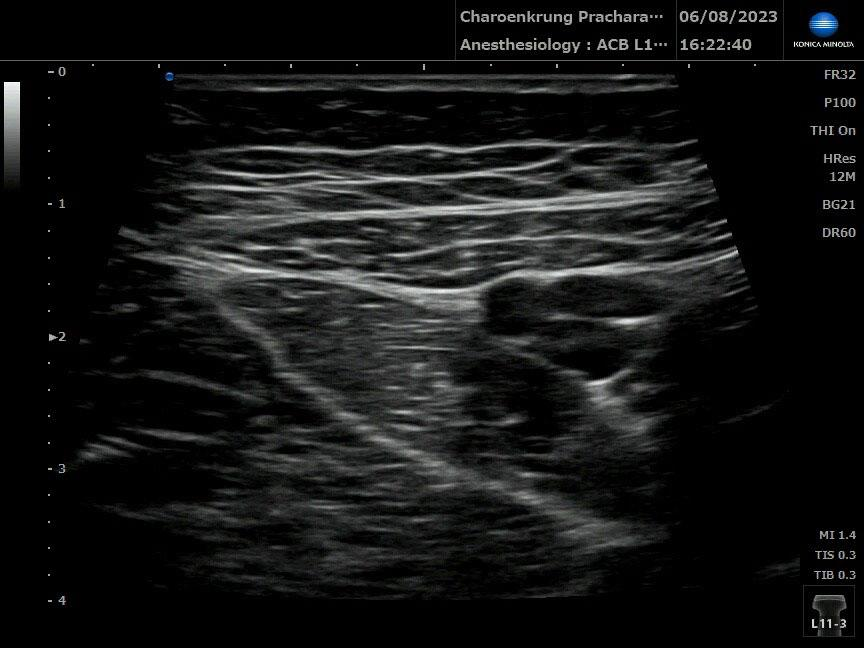

In [ ]:
image = test_dataset[0]['pixel_values']
gt_seg = test_dataset[0]['label']
image

In [ ]:
# inference time
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = tuned_model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

In [ ]:
pred_seg

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
def med_palette():
    """medical palette (self-defined) that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
    ]

In [ ]:
import numpy as np

# to overlay the prediction mask onto an image
def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(med_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

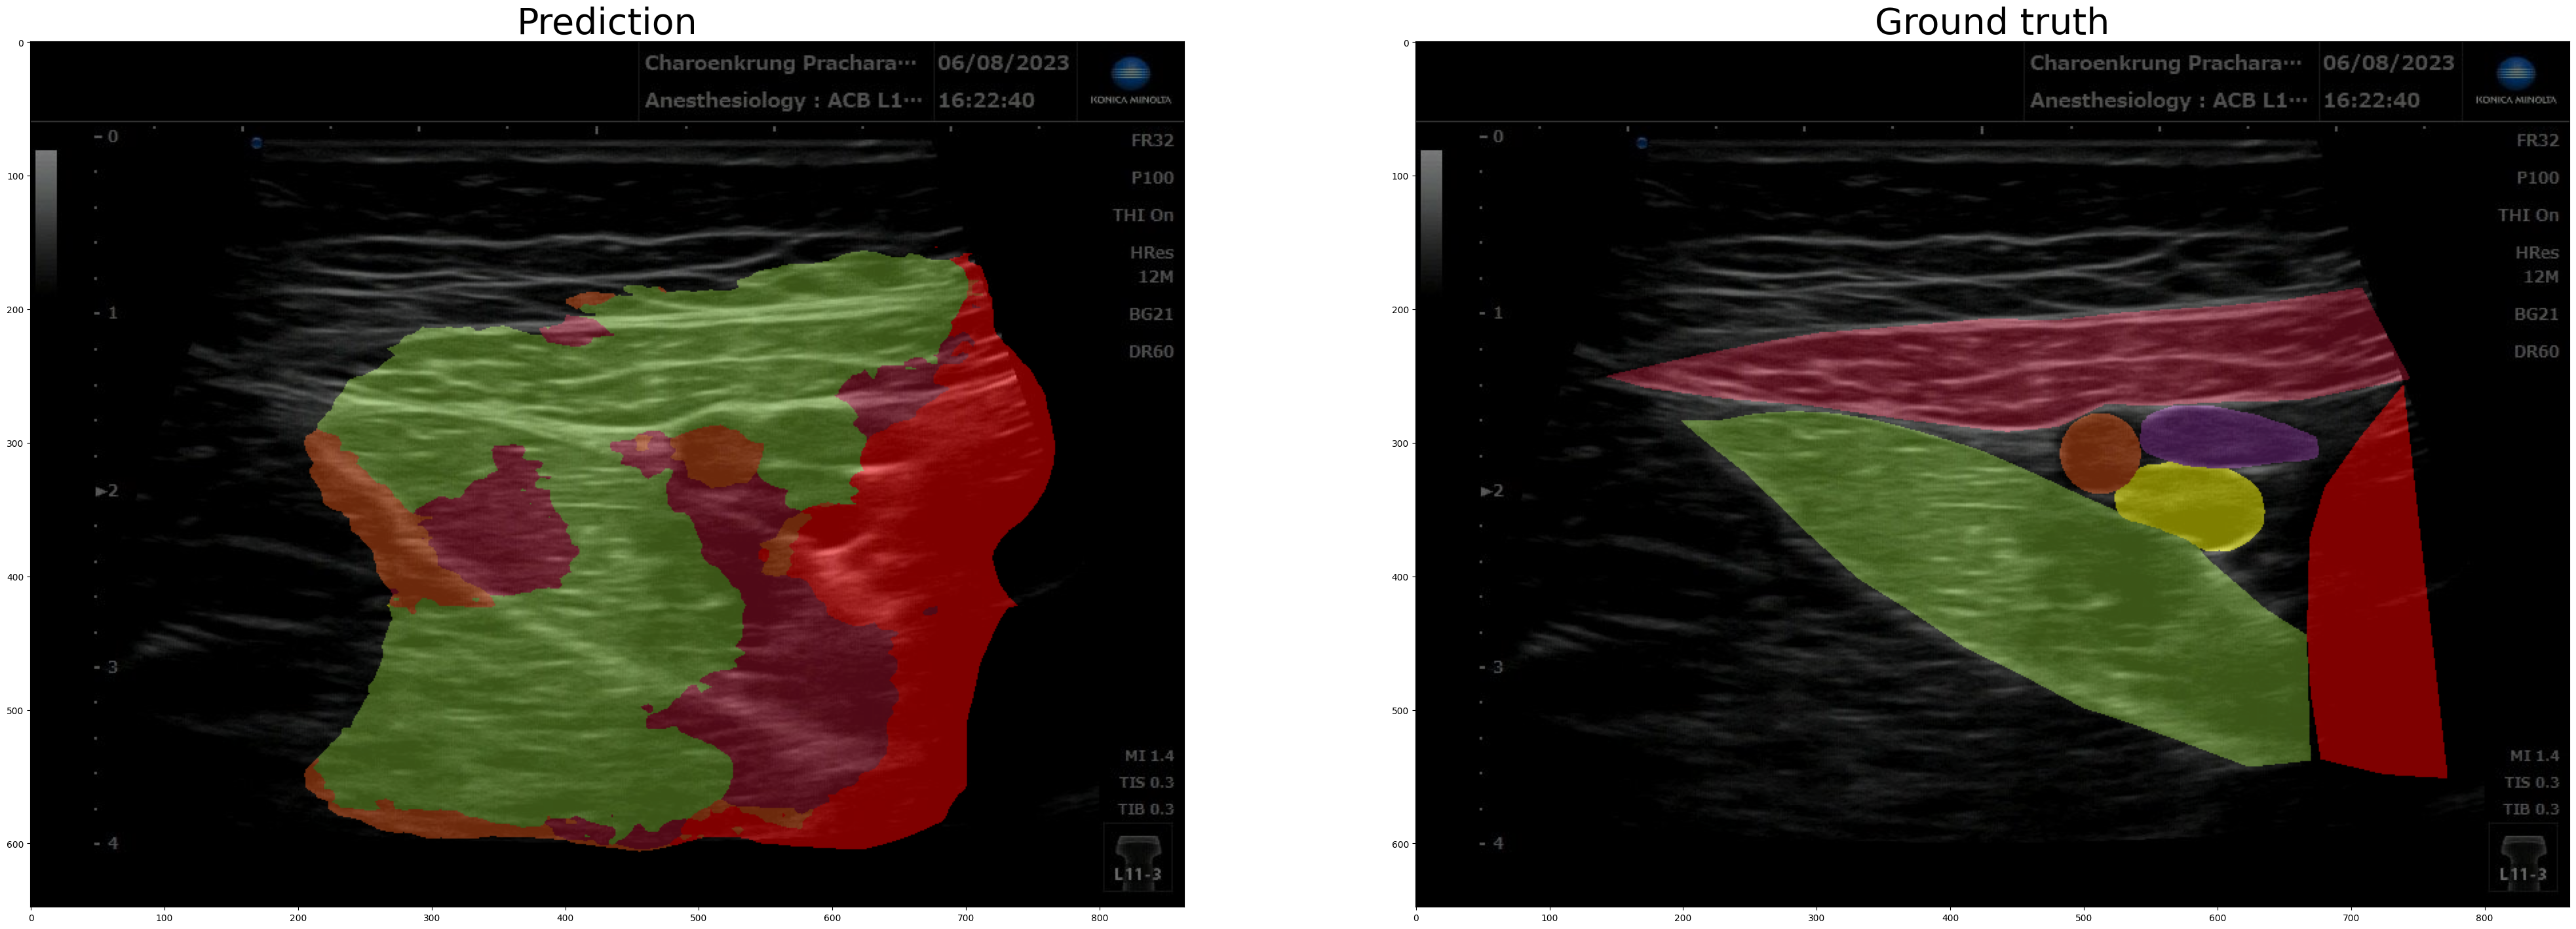

In [ ]:
import matplotlib.pyplot as plt
# overlay an image to the plot
pred_img = get_seg_overlay(image, pred_seg)
gt_img = get_seg_overlay(image, np.array(gt_seg))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {'fontsize': 40})
axs[0].imshow(pred_img)
axs[1].set_title("Ground truth", {'fontsize': 40})
axs[1].imshow(gt_img)